In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

In [2]:
curve = [
    "Apr'21", 2.921,
    "May'21", 2.892,
    "Jun'21", 2.922,
    "Jul'21", 2.96,
    "Aug'21", 2.974,
    "Sep'21", 2.966,
    "Oct'21", 3.007,
    "Nov'21", 3.07,
    "Dec'21", 3.203,
    "Jan'22", 3.294,
    "Feb'22", 3.216,
    "Mar'22", 3.03,
    "Apr'22", 2.568,
    "May'22", 2.48,
    "Jun'22", 2.525,
    "Jul'22", 2.562,
    "Aug'22", 2.57,
    "Sep'22", 2.559,
    "Oct'22", 2.592,
    "Nov'22", 2.681,
    "Dec'22", 2.87,
    "Jan'23", 2.987,
    "Feb'23", 2.939,
    "Mar'23", 2.779,
    "Apr'23", 2.388
]

In [3]:
df = pd.DataFrame( data={ 'Contract': curve[0::2], 'Price': curve[1::2]})

/home/marcino/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Contract'>

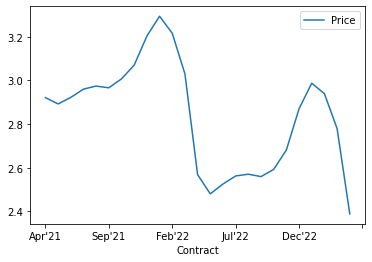

In [4]:
df.plot(x='Contract', y='Price')

In [5]:
N=3 # number of months to use
max_storage_capacity=100000
max_daily_injection=pd.DataFrame(data=[(0,8000),(0.5,8000),(0.5001,8000),(1.0,8000)], columns=['ratchet', 'mdiq'] )
max_daily_withdrawal=pd.DataFrame( data=[(0,9000),(0.5,9000),(0.5001,9000),(1.0,9000)], columns=['ratchet', 'mdwq'] )

<AxesSubplot:xlabel='ratchet'>

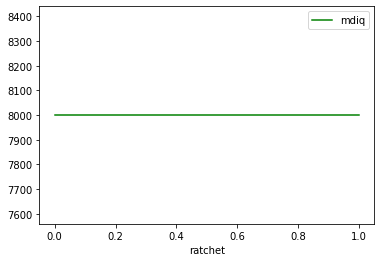

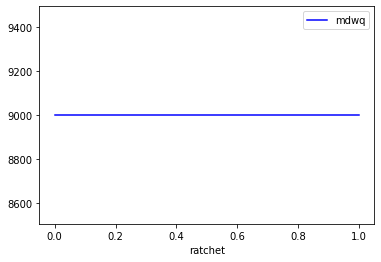

In [6]:
max_daily_injection.plot(x='ratchet',y='mdiq', style='g-')
max_daily_withdrawal.plot(x='ratchet',y='mdwq',style='b-')

In [7]:
m = gp.Model('Gas Storage No Ratchets Daily')
# injection / withdrawal quantities
I = m.addVars(range(N), vtype=GRB.INTEGER, name='I')
W = m.addVars(range(N), vtype=GRB.INTEGER, name='W')


Restricted license - for non-production use only - expires 2022-01-13


In [8]:
# number of days in each injection / drawing month
days = list( map( lambda x: ((x+pd.DateOffset(months=1))-x).days, df.Contract.apply( lambda x: pd.to_datetime( '1-' + x ))))
days[0] = 2
days[1] = 2
days[2] = 2

# number of calendar days in the simulation
M = sum( days[0:N])

prices = list(df.Price)

In [9]:
injection_charges=[None]*N
total_injection=[None]*N
daily_injection=[None]*M

# for each injection month
for i in range(N):
    total_injection[i] = I[i]*10000
    injection_charges[i] = -total_injection[i] * prices[i]
    
for i in range(N):
    lb = sum(days[0:i])
    ub = sum(days[:i+1])
    daily_injection[lb:ub] = [ total_injection[i] / days[i] ] * days[i]

withdrawal_credit=[None]*N
total_draw=[None]*N
daily_draw=[None]*M

# for each drawing month
for j in range(N):
    total_draw[j] = W[j]*10000
    withdrawal_credit[j] = total_draw[j] * prices[j]
    
for i in range(N):
    lb = sum(days[0:i])
    ub = sum(days[:i+1])
    daily_draw[lb:ub]  = [ total_draw[i] / days[i] ] * days[i]

daily_storage=[None]*M
for i in range(M):
    if i == 0:
        daily_storage[i] = daily_injection[i] - daily_draw[i]
    else:
        daily_storage[i] = daily_injection[i] - daily_draw[i] + daily_storage[i-1]

In [15]:
# target function
m.setObjective( gp.quicksum(withdrawal_credit) + gp.quicksum(injection_charges), GRB.MAXIMIZE )

# add constraints
for i in range(M):
    m.addConstr( daily_storage[i] >= 0, f'daily_storage gt 0 for {i}' )
    m.addConstr( daily_storage[i] <= max_storage_capacity, f'daily_storage le max for {i}' ) 
    
# storage is empty on day 0
m.addConstr( daily_injection[0] <= max_daily_injection.loc[0, 'mdiq'], 'daily_injection 0' )
m.addConstr( daily_draw[0] <= max_daily_withdrawal.loc[ 0, 'mdwq'], 'daily draw 0' )

for i in range(M-1):
    m.addConstr( daily_injection[i+1] <= max_daily_injection.loc[0, 'mdiq'], f'daily_injection {i+1}' )
    m.addConstr( daily_draw[i+1] <= max_daily_withdrawal.loc[ 0, 'mdwq'], f'daily draw {i+1}' )

# ensure that storage on last day is empty
m.addConstr( daily_storage[M-1] == 0, 'storage on last day is empty' )

<gurobi.Constr *Awaiting Model Update*>

In [16]:
m.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 50 rows, 6 columns and 132 nonzeros
Model fingerprint: 0xbfd4d688
Variable types: 0 continuous, 6 integer (0 binary)
Coefficient statistics:
  Matrix range     [5e+03, 1e+04]
  Objective range  [3e+04, 3e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+03, 1e+05]

Loaded MIP start from previous solve with objective -290

Presolve removed 50 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.06 seconds
Thread count was 1 (of 4 available processors)

Solution count 2: 300 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+02, best bound 3.000000000000e+02, gap 0.0000%


In [19]:
m.getVars()

[<gurobi.Var I[0] (value -0.0)>,
 <gurobi.Var I[1] (value 1.0)>,
 <gurobi.Var I[2] (value 0.0)>,
 <gurobi.Var W[0] (value -0.0)>,
 <gurobi.Var W[1] (value -0.0)>,
 <gurobi.Var W[2] (value 1.0)>]

In [25]:
dfres = pd.DataFrame( [ x.getValue() for x in daily_storage ], columns=['daily_storage'] )

<AxesSubplot:>

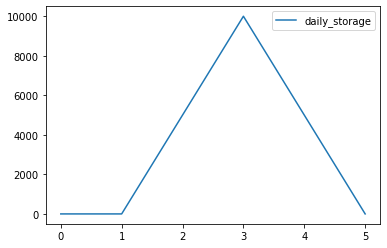

In [26]:
dfres.plot()